In [1]:
# Author: Arthur Prigent
# Email: aprigent@geomar.de

#### DATA ####
# https://downloads.psl.noaa.gov/Datasets/
    

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import scipy.stats as stats
from datetime import *
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

now = datetime.now()
date_time = now.strftime("%d/%m/%Y")


def nandetrend(y):
    ''' Remove the linear trend from the data '''
    
    x = np.arange(0,y.shape[0],1)
    m, b, r_val, p_val, std_err = stats.linregress(x,np.array(y))
    y_detrended= np.array(y) - m*x -b
    return y_detrended


def ano_norm_t(ds):
    
    '''Compute the anomalies by removing the monthly means. 
    The anomalies are normalized by their corresponding month.
    
    Parameters
    ----------
    
    ds : xarray_like
    Timeserie or 3d field.
    
    Returns
    -----------
    
    ano : xarray_like
    Returns the anomalies of var relative the climatology.
    
    ano_norm : xarray_like
    Returns the anomalies of var relative the climatology normalized by the standard deviation.
    
    '''    

    clim     = ds.groupby('time.month').mean('time')
    clim_std = ds.groupby('time.month').std('time')
    ano      = ds.groupby('time.month') - clim
    ano_norm = xr.apply_ufunc(lambda x, m, s: (x - m) / s,
                                    ds.groupby('time.month'),
                                    clim, clim_std)
    
    return ano, ano_norm 




def ano_norm_t_wk(ds):
    
    '''Compute the anomalies by removing the monthly means. 
    The anomalies are normalized by their corresponding month.
    
    Parameters
    ----------
    
    ds : xarray_like
    Timeserie or 3d field.
    
    Returns
    -----------
    
    ano : xarray_like
    Returns the anomalies of var relative the climatology.
    
    ano_norm : xarray_like
    Returns the anomalies of var relative the climatology normalized by the standard deviation.
    
    '''    

    clim     = ds.groupby('time.week').mean('time')
    clim_std = ds.groupby('time.week').std('time')
    ano      = ds.groupby('time.week') - clim
    ano_norm = xr.apply_ufunc(lambda x, m, s: (x - m) / s,
                                    ds.groupby('time.week'),
                                    clim, clim_std)
    
    return ano, ano_norm 


def read_data_compute_anomalies_week(path_data):
    
    ds = xr.open_dataset(path_data+'sst.wkmean.1990-present.nc',engine='pydap')
    mask = xr.open_dataset(path_data+'lsmask.nc',engine='pydap')
    ds = ds.sst.where(mask.mask[0,:,:]==1)
    sst= ds.sel(time=slice(datetime(1990, 1, 1), now))
    sst = xr.concat([sst[:, :, 180:], sst[:, :, :180]], dim='lon')
    sst.coords['lon'] = (sst.coords['lon'] + 180) % 360 - 180  
    
    
    ## Make sub areas ##
    sst_atl3 = sst.where((  sst.lon>=-20) & (sst.lon<=0) &
                           (sst.lat<=3) & (sst.lat>=-3),drop=True).mean(dim='lon').mean(dim='lat')
    sst_nino34 = sst.where(( sst.lon>=-170) & (sst.lon<=-120) &
                           (sst.lat<=5) & (sst.lat>=-5),drop=True).mean(dim='lon').mean(dim='lat')
    sst_aba = sst.where((  sst.lon>=8) & (sst.lon<=16) &
                           (sst.lat<=-10) & (sst.lat>=-20),drop=True).mean(dim='lon').mean(dim='lat')
    
    
    ## Linearly detrend the data ## 
    sst_atl3 = sst_atl3.assign_coords(sst_dtd=('time',  nandetrend(sst_atl3.values)))
    sst_nino34 = sst_nino34.assign_coords(sst_dtd=('time',  nandetrend(sst_nino34.values)))
    sst_aba = sst_aba.assign_coords(sst_dtd=('time',  nandetrend(sst_aba.values)))
    
    

    ## Compute the SST anomalies ## 

    
    ssta_atl3,ssta_atl3_norm = ano_norm_t(sst_atl3.sst_dtd.load())
    ssta_nino34,ssta_nino34_norm = ano_norm_t(sst_nino34.sst_dtd.load())
    ssta_aba,ssta_aba_norm = ano_norm_t(sst_aba.sst_dtd.load())
    
    
    return ssta_atl3_norm,ssta_aba_norm,ssta_nino34_norm


def read_data_compute_anomalies_oi(path_data):
    
    ds = xr.open_dataset(path_data+'sst.mnmean.nc',engine='pydap')
    mask = xr.open_dataset(path_data+'lsmask.nc',engine='pydap')
    ds = ds.sst.where(mask.mask[0,:,:]==1)
    sst= ds.sel(time=slice(datetime(1982, 1, 1), now))
    sst = xr.concat([sst[:, :, 180:], sst[:, :, :180]], dim='lon')
    sst.coords['lon'] = (sst.coords['lon'] + 180) % 360 - 180  
    
    
    ## Make sub areas ##
    sst_atl3 = sst.where((  sst.lon>=-20) & (sst.lon<=0) &
                           (sst.lat<=3) & (sst.lat>=-3),drop=True).mean(dim='lon').mean(dim='lat')
    sst_nino34 = sst.where(( sst.lon>=-170) & (sst.lon<=-120) &
                           (sst.lat<=5) & (sst.lat>=-5),drop=True).mean(dim='lon').mean(dim='lat')
    sst_aba = sst.where((  sst.lon>=8) & (sst.lon<=16) &
                           (sst.lat<=-10) & (sst.lat>=-20),drop=True).mean(dim='lon').mean(dim='lat')
    
    
    ## Linearly detrend the data ## 
    sst_atl3 = sst_atl3.assign_coords(sst_dtd=('time',  nandetrend(sst_atl3.values)))
    sst_nino34 = sst_nino34.assign_coords(sst_dtd=('time',  nandetrend(sst_nino34.values)))
    sst_aba = sst_aba.assign_coords(sst_dtd=('time',  nandetrend(sst_aba.values)))
    
    

    ## Compute the SST anomalies ## 

    
    ssta_atl3,ssta_atl3_norm = ano_norm_t(sst_atl3.sst_dtd.load())
    ssta_nino34,ssta_nino34_norm = ano_norm_t(sst_nino34.sst_dtd.load())
    ssta_aba,ssta_aba_norm = ano_norm_t(sst_aba.sst_dtd.load())
    
    
    return ssta_atl3_norm,ssta_aba_norm,ssta_nino34_norm


def read_data_compute_anomalies(path_data):
    
    ds = xr.open_dataset(path_data,engine='pydap')
    sst= ds.sst.sel(time=slice(datetime(1982, 1, 1), now))
    sst = xr.concat([sst[:, :, 180:], sst[:, :, :180]], dim='lon')
    sst.coords['lon'] = (sst.coords['lon'] + 180) % 360 - 180  
    
    
    ## Make sub areas ##
    sst_atl3 = sst.where((  sst.lon>=-20) & (sst.lon<=0) &
                           (sst.lat<=3) & (sst.lat>=-3),drop=True).mean(dim='lon').mean(dim='lat')
    sst_nino34 = sst.where(( sst.lon>=-170) & (sst.lon<=-120) &
                           (sst.lat<=5) & (sst.lat>=-5),drop=True).mean(dim='lon').mean(dim='lat')
    sst_aba = sst.where((  sst.lon>=8) & (sst.lon<=16) &
                           (sst.lat<=-10) & (sst.lat>=-20),drop=True).mean(dim='lon').mean(dim='lat')
    
    
    ## Linearly detrend the data ## 
    sst_atl3 = sst_atl3.assign_coords(sst_dtd=('time',  nandetrend(sst_atl3.values)))
    sst_nino34 = sst_nino34.assign_coords(sst_dtd=('time',  nandetrend(sst_nino34.values)))
    sst_aba = sst_aba.assign_coords(sst_dtd=('time',  nandetrend(sst_aba.values)))
    
    

    ## Compute the SST anomalies ## 

    
    ssta_atl3,ssta_atl3_norm = ano_norm_t(sst_atl3.sst_dtd.load())
    ssta_nino34,ssta_nino34_norm = ano_norm_t(sst_nino34.sst_dtd.load())
    ssta_aba,ssta_aba_norm = ano_norm_t(sst_aba.sst_dtd.load())
    
    
    return ssta_atl3_norm,ssta_aba_norm,ssta_nino34_norm


def read_data_compute_anomalies_ersstv5(path_data):
    
    ds = xr.open_dataset(path_data,engine='pydap')
    sst= ds.sst.sel(time=slice(datetime(1982, 1, 1), now))
    sst = xr.concat([sst[:, :, 90:], sst[:, :, :90]], dim='lon')
    sst.coords['lon'] = (sst.coords['lon'] + 180) % 360 - 180  
    
    ## Make sub areas ##
    sst_atl3 = sst.where((  sst.lon>=-20) & (sst.lon<=0) &
                           (sst.lat<=3) & (sst.lat>=-3),drop=True).mean(dim='lon').mean(dim='lat')
    sst_nino34 = sst.where(( sst.lon>=-170) & (sst.lon<=-120) &
                           (sst.lat<=5) & (sst.lat>=-5),drop=True).mean(dim='lon').mean(dim='lat')
    sst_aba = sst.where((  sst.lon>=8) & (sst.lon<=16) &
                           (sst.lat<=-10) & (sst.lat>=-20),drop=True).mean(dim='lon').mean(dim='lat')
    
    
    ## Linearly detrend the data ## 
    sst_atl3 = sst_atl3.assign_coords(sst_dtd=('time',  nandetrend(sst_atl3.values)))
    sst_nino34 = sst_nino34.assign_coords(sst_dtd=('time',  nandetrend(sst_nino34.values)))
    sst_aba = sst_aba.assign_coords(sst_dtd=('time',  nandetrend(sst_aba.values)))
    
    

    ## Compute the SST anomalies ## 

    
    ssta_atl3,ssta_atl3_norm = ano_norm_t(sst_atl3.sst_dtd.load())
    ssta_nino34,ssta_nino34_norm = ano_norm_t(sst_nino34.sst_dtd.load())
    ssta_aba,ssta_aba_norm = ano_norm_t(sst_aba.sst_dtd.load())
    
    
    return ssta_atl3_norm,ssta_aba_norm,ssta_nino34_norm


def plot_anomalies(ssta_atl3,ssta_aba,ssta_nino34):
    
    f,ax = plt.subplots(3,1,figsize=[15,15])
    color_lines='grey'
    ftz=15
    ax=ax.ravel()

    
    ### ATL3 ###
    ax[0].axhline(0,color=color_lines)
    ax[0].axhline(1,color=color_lines,linestyle='--')
    ax[0].axhline(-1,color=color_lines,linestyle='--')
    ax[0].plot(ssta_atl3.time.values,ssta_atl3,color='black')
    years = mdates.YearLocator(5)   # every year
    years_minor = mdates.YearLocator(1)  # every month
    ax[0].xaxis.set_major_locator(years)
    ax[0].xaxis.set_minor_locator(years_minor)
    myFmt = mdates.DateFormatter('%Y')
    ax[0].xaxis.set_major_formatter(myFmt)
    ax[0].tick_params(labelsize=ftz)
    ax[0].fill_between(ssta_atl3.time.values,ssta_atl3,1,ssta_atl3>1,color='red')
    ax[0].fill_between(ssta_atl3.time.values,ssta_atl3,-1,ssta_atl3<-1,color='blue')
    ax[0].set_title('Normalized SST anomalies ATL3 [20$^{\circ}$W-0; 3$^{\circ}$S-3$^{\circ}$N] | Baseline '+str(ssta_atl3.time.values[0])[:7] +' --> '+str(ssta_atl3.time.values[-1])[:7],fontsize=ftz,fontweight='bold')
    ax[0].text(0.01,0.04,'Updated '+date_time,transform=ax[0].transAxes,
           size=ftz,
           weight='bold')
    ax[0].set_ylim([-3,3])
    
    
    ### ABA ###
    ax[1].set_title('Normalized SST anomalies ABA [8$^{\circ}$E-16$^{\circ}$E; 20$^{\circ}$S-10$^{\circ}$S] | Baseline '+str(ssta_aba.time.values[0])[:7] +' --> '+str(ssta_aba.time.values[-1])[:7],fontsize=ftz,fontweight='bold')
    ax[1].plot(ssta_aba.time,ssta_aba,color='black')
    ax[1].axhline(0,color=color_lines)
    ax[1].axhline(1,color=color_lines,linestyle='--')
    ax[1].axhline(-1,color=color_lines,linestyle='--')
    ax[1].text(0.01,0.04,'Updated '+date_time,transform=ax[1].transAxes,
           size=ftz,
           weight='bold')
    years = mdates.YearLocator(5)   # every 5 years
    years_minor = mdates.YearLocator(1)  # every year
    ax[1].xaxis.set_major_locator(years)
    ax[1].xaxis.set_minor_locator(years_minor)
    myFmt = mdates.DateFormatter('%Y')
    ax[1].xaxis.set_major_formatter(myFmt)
    ax[1].tick_params(labelsize=ftz)
    ax[1].fill_between(ssta_aba.time.values,ssta_aba,1,ssta_aba>1,color='red')
    ax[1].fill_between(ssta_aba.time.values,ssta_aba,-1,ssta_aba<-1,color='blue')
    ax[1].set_ylim([-3,3])
    
    ### NINO 3.4 ###
    ax[2].set_title('Normalized SST anomalies NINO3.4 [170$^{\circ}$W-120$^{\circ}$W; 5$^{\circ}$S-5$^{\circ}$N] | Baseline '+str(ssta_aba.time.values[0])[:7] +' --> '+str(ssta_aba.time.values[-1])[:7],fontsize=ftz,fontweight='bold')
    ax[2].plot(ssta_nino34.time,ssta_nino34,color='black')
    ax[2].axhline(0,color=color_lines)
    ax[2].axhline(1,color=color_lines,linestyle='--')
    ax[2].axhline(-1,color=color_lines,linestyle='--')
    ax[2].text(0.01,0.04,'Updated '+date_time,transform=ax[2].transAxes,
           size=ftz,
           weight='bold')
    years = mdates.YearLocator(5)   # every 5 years
    years_minor = mdates.YearLocator(1)  # every year
    ax[2].xaxis.set_major_locator(years)
    ax[2].xaxis.set_minor_locator(years_minor)
    myFmt = mdates.DateFormatter('%Y')
    ax[2].xaxis.set_major_formatter(myFmt)
    ax[2].tick_params(labelsize=ftz)
    ax[2].fill_between(ssta_nino34.time.values,ssta_nino34,1,ssta_nino34>1,color='red')
    ax[2].fill_between(ssta_nino34.time.values,ssta_nino34,-1,ssta_nino34<-1,color='blue')
    ax[2].set_ylim([-3,3])


# Last update 

In [2]:
print(str(now)[:16])

2021-06-13 17:16


# Read SST data 

In [3]:
path_oi_wk = 'https://psl.noaa.gov/thredds/dodsC/Datasets/noaa.oisst.v2/'
ssta_atl3_norm_oi_wk,ssta_aba_norm_oi_wk,ssta_nino34_norm_oi_wk = read_data_compute_anomalies_week(path_oi_wk)

In [4]:
path_data = 'https://psl.noaa.gov/thredds/dodsC/Datasets/COBE/sst.mon.mean.nc'
ssta_atl3_norm_cobe,ssta_aba_norm_cobe,ssta_nino34_norm_cobe = read_data_compute_anomalies(path_data)


In [5]:
path_oi = 'https://psl.noaa.gov/thredds/dodsC/Datasets/noaa.oisst.v2/'
ssta_atl3_norm_oi,ssta_aba_norm_oi,ssta_nino34_norm_oi = read_data_compute_anomalies_oi(path_oi)

In [6]:
path_ersstv5 = 'https://psl.noaa.gov/thredds/dodsC/Datasets/noaa.ersst.v5/sst.mnmean.nc'
ssta_atl3_norm_ersst,ssta_aba_norm_ersst,ssta_nino34_norm_ersst = read_data_compute_anomalies_ersstv5(path_ersstv5)

# Timeseries of SST anomalies

# Monthly data


# [COBE SST](https://psl.noaa.gov/data/gridded/data.cobe.html) | 1$^{\circ}$ x 1$^{\circ}$ | Monthly

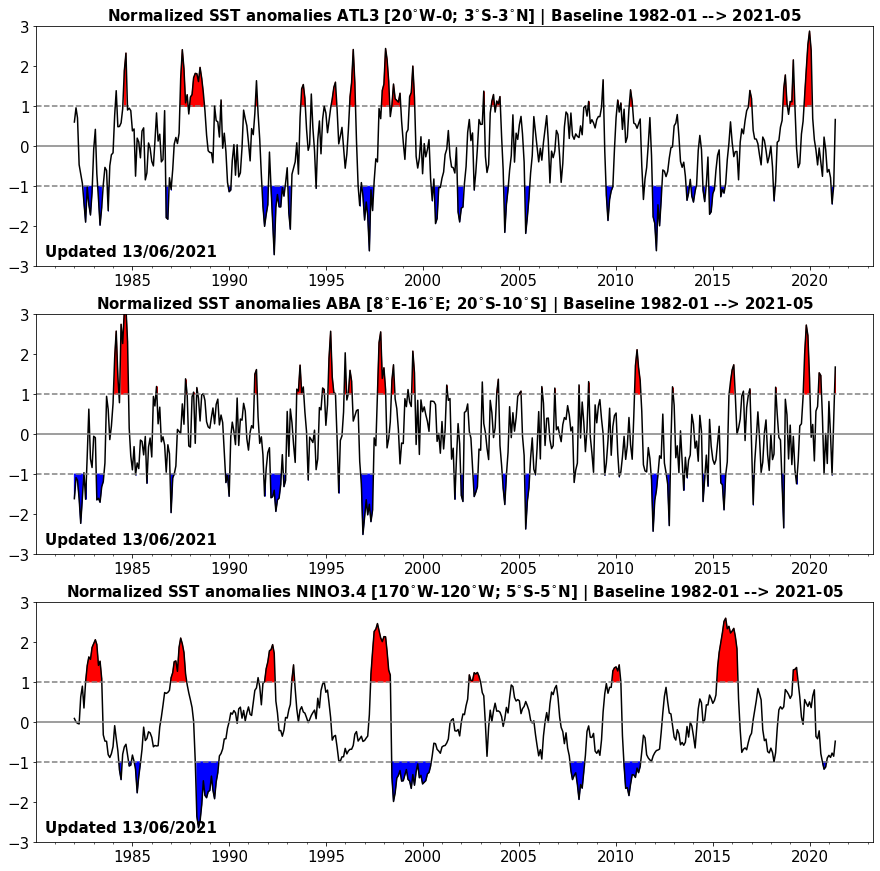

In [7]:
plot_anomalies(ssta_atl3_norm_cobe,ssta_aba_norm_cobe,ssta_nino34_norm_cobe)

# [OI SST v2](https://psl.noaa.gov/data/gridded/data.noaa.oisst.v2.html) | 1$^{\circ}$ x 1$^{\circ}$ | Monthly

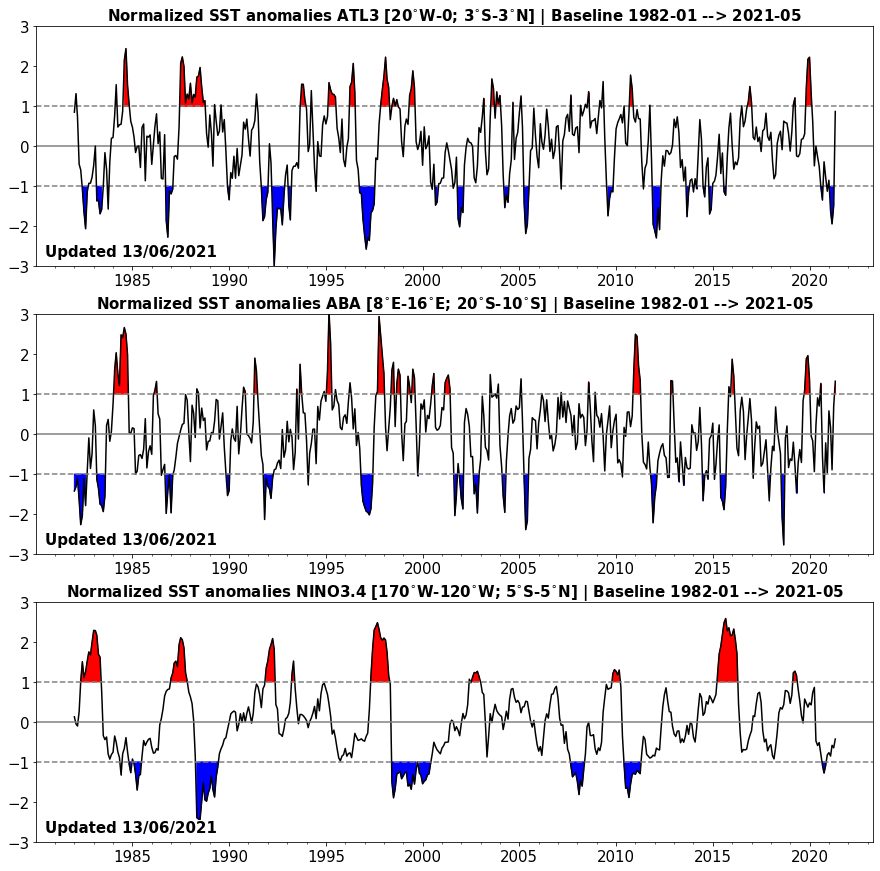

In [8]:
plot_anomalies(ssta_atl3_norm_oi,ssta_aba_norm_oi,ssta_nino34_norm_oi)

# [ERSST V5](https://psl.noaa.gov/data/gridded/data.noaa.ersst.v5.html) | 2$^{\circ}$ x 2$^{\circ}$ | Monthly

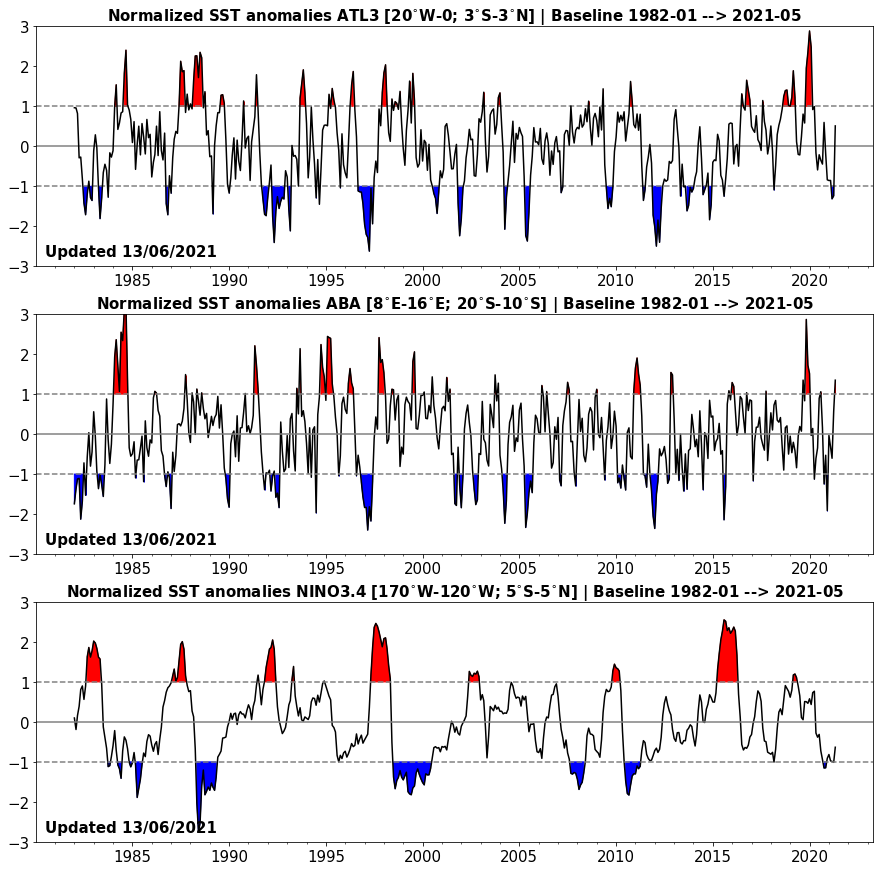

In [9]:
plot_anomalies(ssta_atl3_norm_ersst,ssta_aba_norm_ersst,ssta_nino34_norm_ersst)

# Weekly data

# [OI SST v2](https://psl.noaa.gov/data/gridded/data.noaa.oisst.v2.html) | 1$^{\circ}$ x 1$^{\circ}$ | Weekly

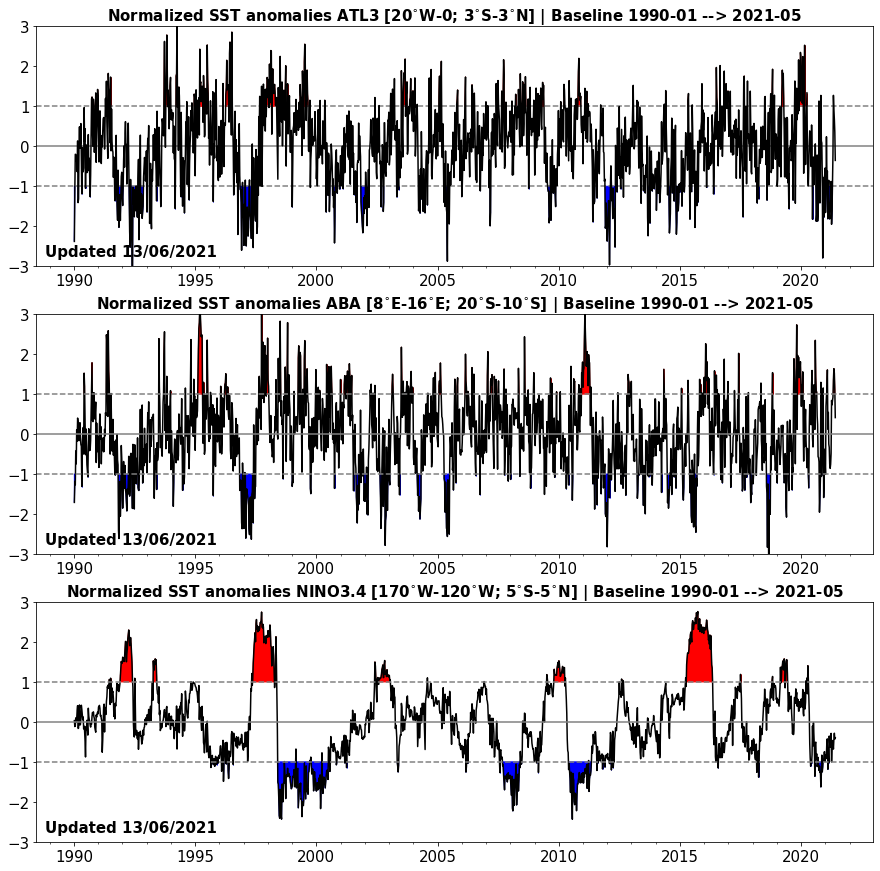

In [10]:
plot_anomalies(ssta_atl3_norm_oi_wk,ssta_aba_norm_oi_wk,ssta_nino34_norm_oi_wk)